<a href="https://colab.research.google.com/github/veronika-guseva79/Practicum/blob/main/pregnancy_risks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача: создать прогностическую модель рисков беременных.


Описание:
Age: Age in years when a woman is pregnant.   
SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.  
DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.  
BS: Blood glucose levels is in terms of a molar concentrationmmol/L.  
HeartRate: A normal resting heart rate in beats per minute.  
Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.



#### Шаг 1. Загрузка данных

In [ ]:
!pip install phik

Загружаем необходимые библиотеки.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
RANDOM_STATE = 42

In [ ]:
df = pd.read_csv('C:\\Users\\N\\Documents\\Документы\\Data science\\Карьерный трек\\Тестовые\\таблица на 2 задание на дата сайенс.csv')
df.head(5)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


#### Шаг 2. Анализ и очистка данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


Пропусков в данных нет. Проверим значения, встречающиеся в каждой колонке.

In [ ]:
df['Age'].sort_values().unique()

array([10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 48, 49, 50, 51, 54, 55, 56, 59, 60, 62, 63, 65, 66, 70],
      dtype=int64)

В колонке "Age" явно встречаются значения за пределами фертильного возраста женщины. Отсеим строки с возрастом младше 15 и старше 55 лет во избежание искажения в модели: если это и реальные случаи, а не ошибки в данных - они являются экстремальными и могут повлиять на обучение модели.

In [ ]:
df=df.loc[(df['Age'] >= 15) & (df['Age'] <= 55)]

In [ ]:
df['Age'].sort_values().unique()

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49,
       50, 51, 54, 55], dtype=int64)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 915 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          915 non-null    int64  
 1   SystolicBP   915 non-null    int64  
 2   DiastolicBP  915 non-null    int64  
 3   BS           915 non-null    float64
 4   BodyTemp     915 non-null    float64
 5   HeartRate    915 non-null    int64  
 6   RiskLevel    915 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 57.2+ KB


Мы удалили 9,8% данных, что допустимо.

In [ ]:
df['SystolicBP'].sort_values().unique()

array([ 70,  75,  76,  78,  80,  83,  85,  90,  95,  99, 100, 110, 115,
       120, 129, 130, 135, 140, 160], dtype=int64)

In [ ]:
df['DiastolicBP'].sort_values().unique()

array([ 49,  50,  60,  63,  65,  68,  69,  70,  75,  76,  80,  85,  89,
        90,  95, 100], dtype=int64)

Значения систолического и диастолического давления выглядят вполне реальными.

In [ ]:
df['BS'].sort_values().unique()

array([ 6.  ,  6.1 ,  6.3 ,  6.4 ,  6.5 ,  6.6 ,  6.7 ,  6.8 ,  6.9 ,
        7.  ,  7.01,  7.1 ,  7.2 ,  7.5 ,  7.6 ,  7.7 ,  7.8 ,  7.9 ,
        8.  ,  9.  , 10.  , 11.  , 12.  , 13.  , 15.  , 16.  , 17.  ,
       18.  , 19.  ])

Значения сахара крови выше 11 считаются экстремальными. Посмотрим на эти строки - есть ли там RiskLevel не "high".

In [ ]:
df.loc[(df['BS'] > 11) & (df['RiskLevel'] != 'high risk') ]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
73,54,130,70,12.0,98.0,67,mid risk
74,44,120,90,16.0,98.0,80,mid risk
77,55,120,90,12.0,98.0,70,mid risk
318,54,130,70,12.0,98.0,67,mid risk
331,44,120,90,16.0,98.0,80,mid risk
334,55,120,90,12.0,98.0,70,mid risk
413,50,130,80,16.0,102.0,76,mid risk
444,43,130,80,18.0,98.0,70,mid risk
460,42,130,80,18.0,98.0,70,mid risk
555,50,130,100,16.0,98.0,75,mid risk


Такого не может быть - удалим строки, где уровень глюкозы выше 11, но не стоит high risk - это явно ошибка в данных, которая может исказить результаты модели.

In [ ]:
df=df.loc[(df['BS'] <= 11) | ((df['BS'] > 11) & (df['RiskLevel'] == 'high risk') )]

In [ ]:
df['BodyTemp'].sort_values().unique()

array([ 98. ,  98.4,  98.6,  99. , 100. , 101. , 102. , 103. ])

Температура в градусах по Фаренгейту от 98(36,6) до 104 (40). Здесь все в пределах.

In [ ]:
df['HeartRate'].sort_values().unique()

array([ 7, 60, 66, 67, 68, 70, 75, 76, 77, 78, 80, 82, 86, 88, 90],
      dtype=int64)

Пульс не может быть равен 7 ударам в минуту. Удалим эти строки.

In [ ]:
df.loc[df['HeartRate'] == 7]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


In [ ]:
df=df.loc[df['HeartRate'] > 7]

In [ ]:
df['RiskLevel'].sort_values().unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 894 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          894 non-null    int64  
 1   SystolicBP   894 non-null    int64  
 2   DiastolicBP  894 non-null    int64  
 3   BS           894 non-null    float64
 4   BodyTemp     894 non-null    float64
 5   HeartRate    894 non-null    int64  
 6   RiskLevel    894 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.9+ KB


Итак, мы удалили 120 строк, что является около 12% данных.

#### Шаг 3. Исследовательский анализ данных

Посмотрим на распределение признаков.

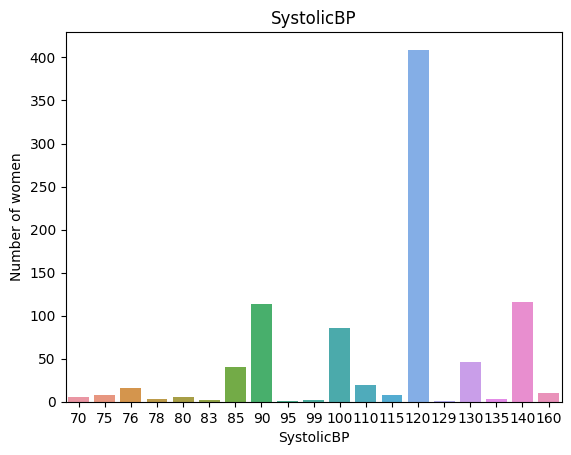

In [ ]:
sns.countplot(df['SystolicBP']);
plt.title('SystolicBP');
plt.ylabel('Number of women');

Большинство женщин имеет нормальное систолическое давление 120 мм рт.ст. Но также есть низкие значения до 70 и высокие о 160 мм рт. ст.

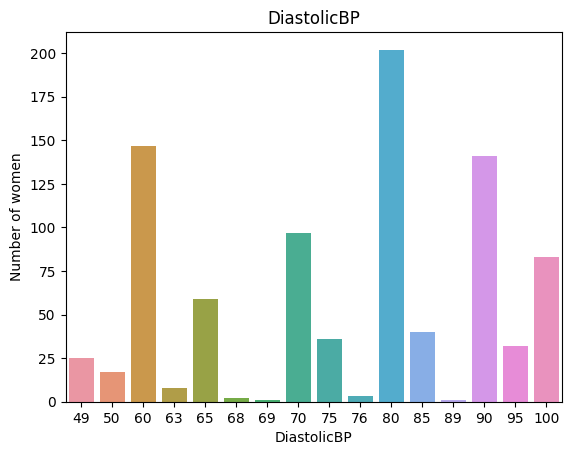

In [ ]:
sns.countplot(df['DiastolicBP']);
plt.title('DiastolicBP');
plt.ylabel('Number of women');

Большинство женщин имеет нормальное диастолическое давление 80 мм рт.ст. Здесь разброс больше - многи еимеют 60 и 90 мм рт.ст, также встречаются низкие значения до 49 и высокие до 100 мм рт. ст.

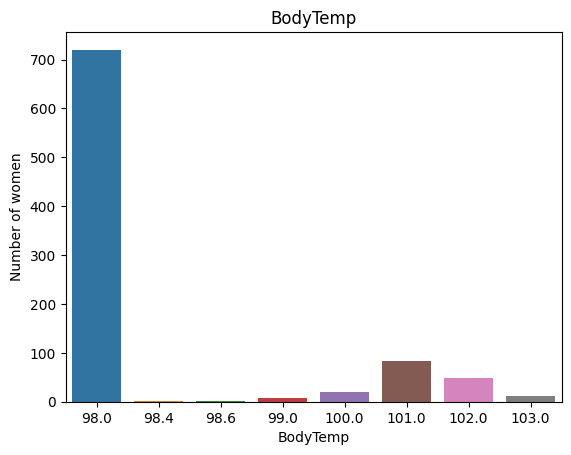

In [ ]:
sns.countplot(df['BodyTemp']);
plt.title('BodyTemp');
plt.ylabel('Number of women');

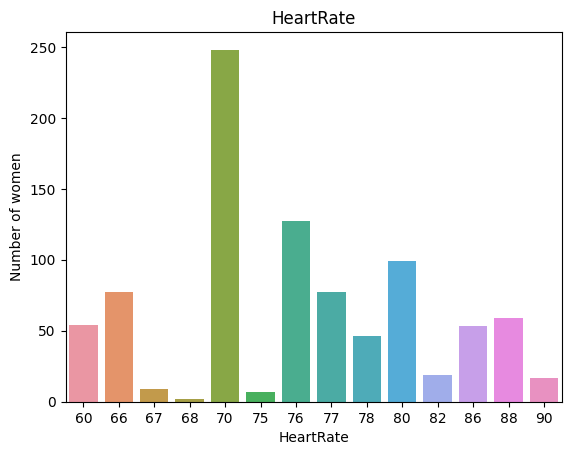

In [ ]:
sns.countplot(df['HeartRate']);
plt.title('HeartRate');
plt.ylabel('Number of women');

Распределение сердечного ритма от 60 до 90 ударов в минуту.Больше всего женщин имеет пульс 70 ударов в минуту.

Возраст - не дискретная величина, поэтому рассмотрим гистограммы распределения и размаха.

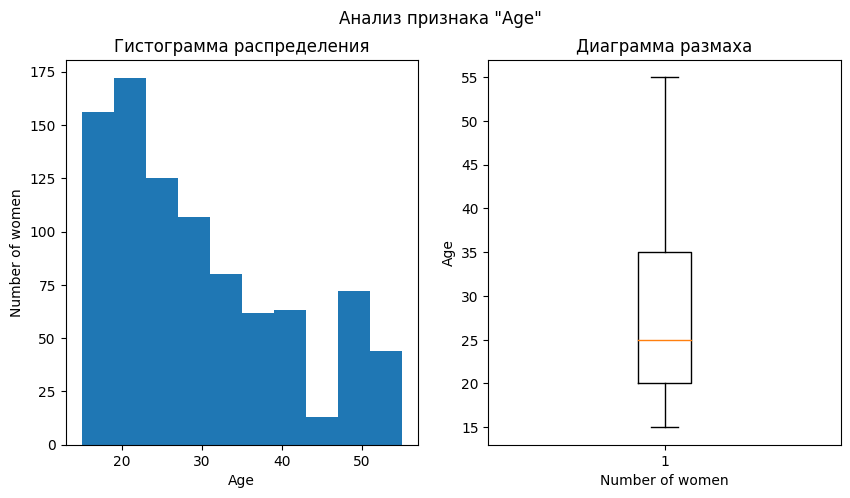

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle(f'Анализ признака "Age"')
axes[0].hist(df['Age']);
axes[0].set_xlabel('Age');
axes[0].set_ylabel('Number of women');
axes[0].set_title('Гистограмма распределения');
axes[1].boxplot(df['Age']);
axes[1].set_title('Диаграмма размаха');
axes[1].set_xlabel('Number of women');
axes[1].set_ylabel('Age');

Распределение возраста не похоже на нормальное - сильный уклон в сторону молодого возраста. Мало женщин в возрасте около 45 лет. Выбросов нет (видимо, после того, как имы удалили слишком молодых и слишком пожилых).

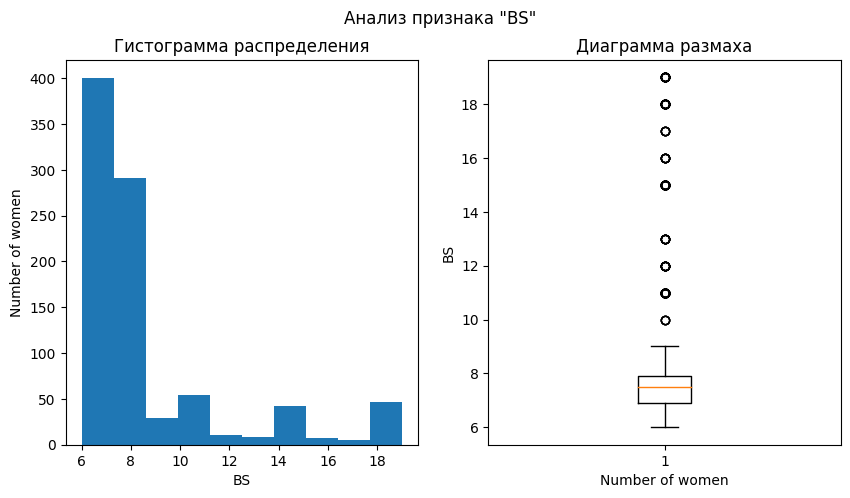

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle(f'Анализ признака "BS"')
axes[0].hist(df['BS']);
axes[0].set_xlabel('BS');
axes[0].set_ylabel('Number of women');
axes[0].set_title('Гистограмма распределения');
axes[1].boxplot(df['BS']);
axes[1].set_title('Диаграмма размаха');
axes[1].set_xlabel('Number of women');
axes[1].set_ylabel('BS');

Распределение уровня сахара также а не похоже на нормальное - больше всего женщин имеет уровен около 6-8 ммоль/л. Выбросы присутствуют в бОльшую сторону.

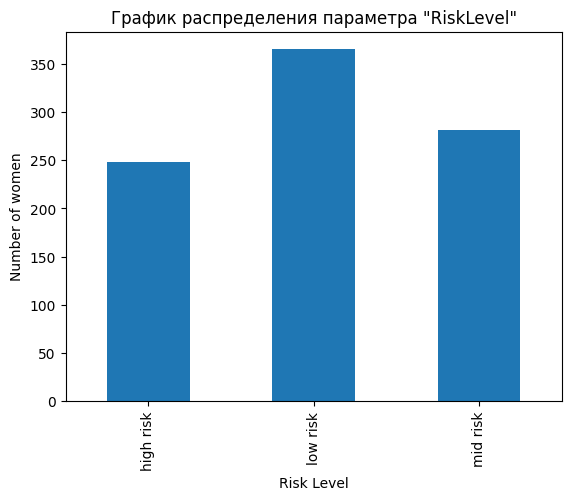

In [ ]:
df.pivot_table(index='RiskLevel', values='Age', aggfunc='count').plot(kind='bar', legend=False);
plt.title(f'График распределения параметра "RiskLevel"');
plt.xlabel('Risk Level');
plt.ylabel('Number of women');


Целевой признак: низкий риск имеет большинство женщин - около 40%, средний и высокий риск - примерно одинаковое количество женщин (около 30% каждая группа). Необходима стратификация тренировочной и тестовой выборок, чтоюы избежать искажения результатов моделирования.

Проведем анализ корреляции признаков.

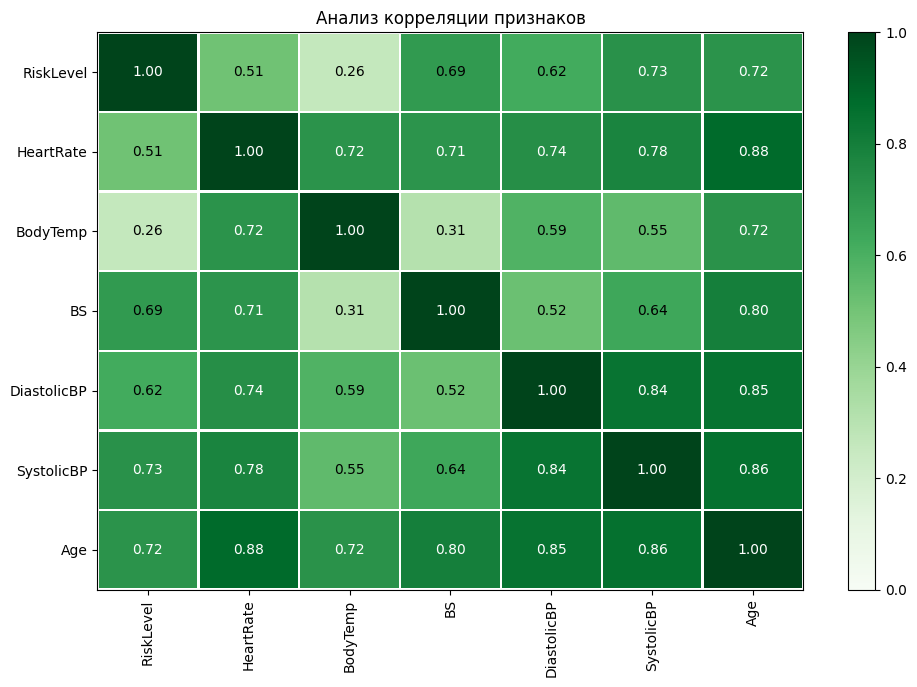

In [ ]:
df= df.loc[: , df.columns != 'index']
interval_columns=['age', 'BS' ]
phik_overview = phik_matrix(df, interval_cols=interval_columns)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.0,
    figsize=(10, 7)
)
plt.title('Анализ корреляции признаков');

Мультиколлинеарность (значение коэффициента корреляции более 0.9) между признаками не наблюдается, поэтому удаялять какие-либо признаки нет необходимости. Можно отметить высокий уровень корреляции между целевым признаком "RiskLevel" и входными признаками "Age", "SystolicBP" и а также заметную корреляцию с "Blood sugar" и "DiastolicBP".

#### Шаг 4. Обучение моделей

Разделим выборку на тренировочную (75%) и тестовую (25%) с учетом стратификации целевого признака.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['RiskLevel'], axis=1),
    df['RiskLevel'],
    test_size = 0.25,
    random_state = 42, stratify=df['RiskLevel'])
model=LogisticRegression(random_state=RANDOM_STATE)

Все числовые признаки необходимо отмасштабировать, тк они имеют совершенно разныне шкалы.

In [ ]:
num_columns=['Age','SystolicBP', 'DiastolicBP','BS', 'BodyTemp', 'HeartRate']
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), num_columns)

    ],
    remainder='passthrough'
)

Обучим 3 разных модели классификации: KNN, DecisionTreeClassifier, LogisticRegression - с помощью пайплайна зададим 2 разных способа масштабирования, разные гиперпараметры моделей и применим GridSearchCV для поиска лучшей метрики Accuracy на кросс-валидации. В качестве метрики возьмем Recall так как наиболее важна полнота определения женщин с высоким и средним риском - чтобы их не пропустить и обеспечить им необходимое наблюдение и лечение.

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
param_distributions = [

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]

    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]

    },


    {
        'models': [OneVsRestClassifier(LogisticRegression(random_state=RANDOM_STATE))],
       # 'models__C': range(1,5),

        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
       }


]

In [ ]:
grid_search = GridSearchCV(
    pipe_final,
    param_distributions,
    cv=5,
    scoring='recall_macro',
    n_jobs=-1,
   # random_state=RANDOM_STATE
)

In [ ]:
grid_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', grid_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', round(grid_search.best_score_,2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['Age', 'SystolicBP',
                                                   'DiastolicBP', 'BS',
                                                   'BodyTemp',
                                                   'HeartRate'])])),
                ('models',
                 DecisionTreeClassifier(max_depth=13, random_state=42))])
Метрика лучшей модели на кросс-валидации: {'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 13, 'models__min_samples_leaf': 1, 'models__min_samples_split': 2, 'preprocessor__num': MinMaxScaler()}
Метрика лучшей модели на кросс-валидации: 0.84


Итак, лучшей моделью стало дерево решений: DecisionTreeClassifier(random_state=42), 'models__max_depth': 13, 'models__min_samples_leaf': 1, 'models__min_samples_split': 2, 'preprocessor__num': MinMaxScaler()}
Метрика лучшей модели на кросс-валидации: 0.84

Проверим эту модель на тестовой выборке.

In [ ]:
model_best = grid_search.best_estimator_
predictions = model_best.predict(X_test)
recall_test = recall_score(y_test, predictions, average='macro')
print(f"Recall на тестовой выборке: {recall_test:.2f}")

Recall на тестовой выборке: 0.84


Результат получился такой же - 0.84
Выведем матрицы ошибок для тренировочных и тестовых данных, а также рассчитаем другие метрики.

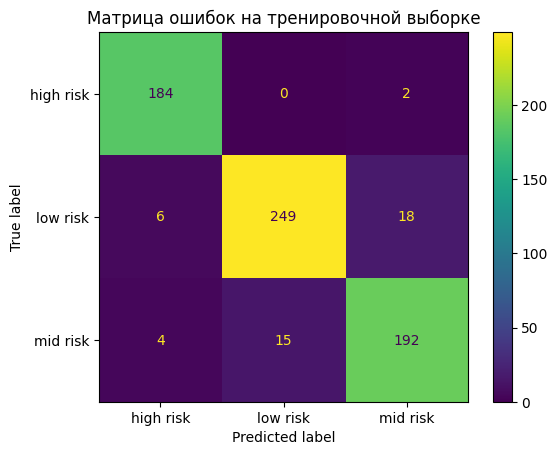

In [ ]:
ConfusionMatrixDisplay.from_estimator(model_best, X_train, y_train)
plt.title('Матрица ошибок на тренировочной выборке');
plt.show()


In [ ]:
predictions_train = model_best.predict(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print(f"Accuracy на тренировочной выборке: {accuracy_train:.4f}")
precision_train = precision_score(y_train, predictions_train, average='macro')
print(f"Precision на тренировочной выборке: {precision_train:.4f}")
recall_train = recall_score(y_train, predictions_train, average='macro')
print(f"recall на тренировочной выборке: {recall_train:.4f}")
f1_train = f1_score(y_train, predictions_train, average='macro')
print(f"F1-мера на тренировочной выборке: {f1_train:.4f}")

Accuracy на тренировочной выборке: 0.9328
Precision на тренировочной выборке: 0.9324
recall на тренировочной выборке: 0.9371
F1-мера на тренировочной выборке: 0.9345


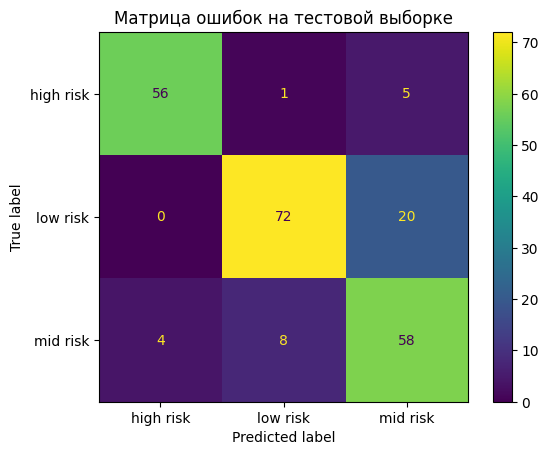

In [ ]:
ConfusionMatrixDisplay.from_estimator(model_best, X_test, y_test)
plt.title('Матрица ошибок на тестовой выборке');
plt.show()


In [ ]:
accuracy_test = accuracy_score(y_test, predictions)
print(f"Accuracy на тестовой выборке: {accuracy_test:.4f}")
precision_test = precision_score(y_test, predictions, average='macro')
print(f"Precision на тестовой выборке: {precision_test:.4f}")
recall_test = recall_score(y_test, predictions, average='macro')
print(f"Recall на тестовой выборке: {recall_test:.4f}")
f1_test = f1_score(y_test, predictions, average='macro')
print(f"F1-мера на тестовой выборке: {f1_test:.4f}")

Accuracy на тестовой выборке: 0.8304
Precision на тестовой выборке: 0.8403
Recall на тестовой выборке: 0.8381
F1-мера на тестовой выборке: 0.8362


#### Шаг 5. Выводы

Итак, в процессе анализа данных мы удалили строки с экстремальными значениями возраста женщин (младше 15 и старше 55), а также строки с экстремально высоким уровнем глюкозы, но не "high risk" в целевом признаке.

Лучшей моделью стало дерево решений: DecisionTreeClassifier(random_state=42), 'models__max_depth': 13, 'models__min_samples_leaf': 1, 'models__min_samples_split': 2, 'preprocessor__num': MinMaxScaler()}
Метрика Recall лучшей модели на кросс-валидации: 0.84.

Accuracy на тестовой выборке: 0.8304
Precision на тестовой выборке: 0.8403
Recall на тестовой выборке: 0.8381
F1-мера на тестовой выборке: 0.8362

Здесь, по моему мнению, наиболее важна метрика Recall (полнота определения женщин с высоким и средним риском - чтобы их не пропустить  обеспечить им необходимое наблюдение и лечение). Она составила 0.84 на тесте, что достаточно высокий результат, но учитывая критичность правильного предсказания для здоровья беременных женщин, нужно работать дальше над его улучшением с помощью улучшения качества данных посредством консультаций с врачами по поводу значений признаков, которые имеет смысл включить/исключить из исследования, рассмотреть различные комбинации признаков/дополнительные признаки (feature engineering).
